In [1]:
# Importing the necessary libraries
import torch
import numpy as np
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import CelebA
from torchvision.utils import make_grid
# from torch.utils.data import DataLoader
from torch.utils.data import DataLoader, Dataset

import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder

torch.manual_seed(0)

### Generator

In [2]:
class Generator(nn.Module):
    
    def __init__(self, z_dim=10, im_chan=3, hidden_dim=64):
        
        super(Generator, self).__init__()
        self.z_dim = z_dim
        
        self.gen = nn.Sequential(
            self.make_gen_block(z_dim, hidden_dim * 8),
            self.make_gen_block(hidden_dim * 8, hidden_dim * 4),
            self.make_gen_block(hidden_dim * 4, hidden_dim * 2),
            self.make_gen_block(hidden_dim * 2, hidden_dim),
            self.make_gen_block(hidden_dim, im_chan, kernel_size=4, final_layer=True),
        )
        
    def make_gen_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
        
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True),
            )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.Tanh(),
            )
        
    def forward(self, noise):
        
        x = noise.view(len(noise), self.z_dim, 1, 1)
        return self.gen(x)    
    
def get_noise(n_samples, z_dim, device='cpu'):
    
    return torch.randn(n_samples, z_dim, device=device)

### Loading the Pre-trained Model

In [3]:
z_dim = 64
image_size = 299
device = 'cpu'

transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset = ImageFolder("dataset/celeba", transform)

In [4]:
gen = Generator(z_dim).to(device)
gen.load_state_dict(torch.load(f"pretrained_celeba.pth", map_location=torch.device(device))["gen"])
gen.eval()

Generator(
  (gen): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(64, 512, kernel_size=(3, 3), stride=(2, 2))
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): ConvTranspose2d(512, 256, kernel_size=(3, 3), stride=(2, 2))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (3): Sequential(
      (0): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (4): Sequential(
      (0): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2

### Inception-v3 Network

In [5]:
from torchvision.models import inception_v3

inception_model = inception_v3(pretrained=False)
inception_model.load_state_dict(torch.load("inception_v3_google-1a9a5a14.pth"))
inception_model.to(device)
inception_model = inception_model.eval()

C:\Users\DESKTOP\anaconda3\envs\specter\lib\site-packages\torchvision\models\inception.py:80: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn('The default weight initialization of inception_v3 will be changed in future releases of '


### Fréchet Inception Distance

In [6]:
inception_model.fc = torch.nn.Identity()

In [7]:
# UNIT TEST
test_identity_noise = torch.randn(100, 100)
assert torch.equal(test_identity_noise, inception_model.fc(test_identity_noise))
print("Success!")

Success!


#### Multivariate Fréchet Distance

C:\Users\DESKTOP\anaconda3\envs\specter\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


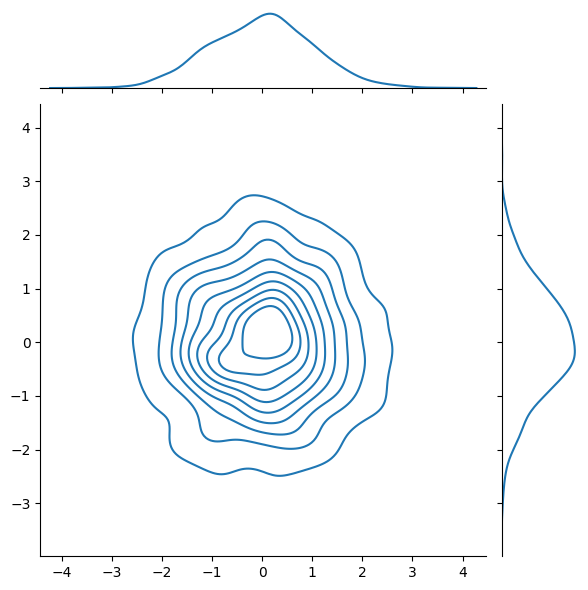

In [8]:
# import os
# os.environ['KMP_DUPLICATE_LIB_OK']='True'
from torch.distributions import MultivariateNormal
import seaborn as sns

mean = torch.Tensor([0, 0])
covariance = torch.Tensor(
    [
        [1, 0],
        [0, 1]
    ]
)

independent_dist = MultivariateNormal(mean, covariance)
samples = independent_dist.sample((1000, ))
res = sns.jointplot(samples[:, 0], samples[:, 1], kind='kde')
plt.show()

C:\Users\DESKTOP\anaconda3\envs\specter\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


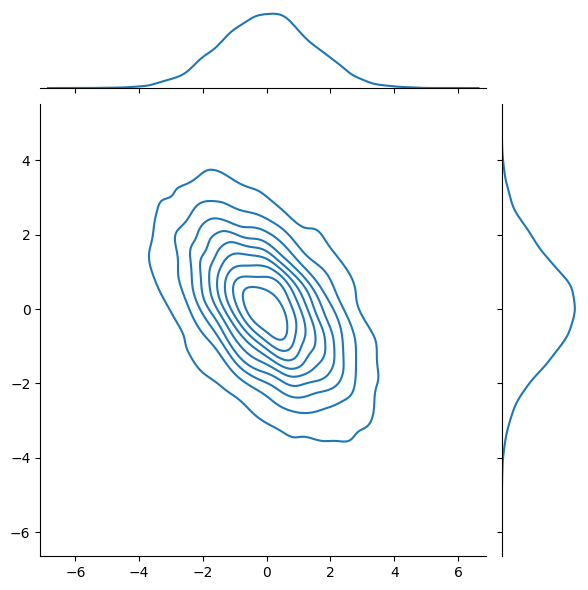

In [9]:
mean = torch.Tensor([0, 0])
covariance = torch.Tensor(
    [[2, -1],
     [-1, 2]]
)
covariant_dist = MultivariateNormal(mean, covariance)
samples = covariant_dist.sample((10000,))
res = sns.jointplot(samples[:, 0], samples[:, 1], kind="kde")
plt.show()

#### Implementing FID

In [10]:
import scipy

def matrix_sqrt(x):
    
    y = x.cpu().detach().numpy()
    y = scipy.linalg.sqrtm(y)
    return torch.Tensor(y.real, device=x.device)

In [11]:
def frechet_distance(mu_x, mu_y, sigma_x, sigma_y):
    
    return torch.norm(mu_x - mu_y) + torch.trace(sigma_x + sigma_y - 2 * matrix_sqrt(sigma_x @ sigma_y))

In [12]:
# UNIT TEST
assert torch.isclose(
    frechet_distance(
        independent_dist.mean, covariant_dist.mean,
        independent_dist.covariance_matrix, covariant_dist.covariance_matrix
    ),
    4 - 2 * torch.sqrt(torch.tensor(3.))
)

print("Success!")

Success!


### Putting it all together

In [13]:
def preprocess(img):
    
    img = torch.nn.functional.interpolate(img, size=(299, 299), mode='bilinear', align_corners=False)
    return img

In [14]:
# Function to calculate the covariance and return a covariance matrix given a list of values
import numpy as np

def get_covariance(features):
    
    return torch.Tensor(np.cov(features.detach().numpy(), rowvar=False))

In [17]:
# Getting the features of the real and fake images using the inception v3 model
fake_features_list = []
real_features_list = []

gen.eval()
n_samples = 512 
batch_size = 4

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

cur_samples = 0

with torch.no_grad(): # You don't need to calculate gradients here, so you do this to save memory
    try:
        for real_example, _ in tqdm(dataloader, total=n_samples // batch_size): # Go by batch
            real_samples = real_example
            real_features = inception_model(real_samples.to(device)).detach().to('cpu') # Move features to CPU
            real_features_list.append(real_features)

            fake_samples = get_noise(len(real_example), z_dim).to(device)
            fake_samples = preprocess(gen(fake_samples))
            fake_features = inception_model(fake_samples.to(device)).detach().to('cpu')
            fake_features_list.append(fake_features)
            cur_samples += len(real_samples)
            if cur_samples >= n_samples:
                break
    except:
        print("Error in loop")

  0%|          | 0/128 [00:00<?, ?it/s]

In [20]:
fake_features_all = torch.cat(fake_features_list)
real_features_all = torch.cat(real_features_list)

In [21]:
# Calculating the covariance and mean of these real and fake features
mu_fake = fake_features_all.mean(0)
mu_real = real_features_all.mean(0)

sigma_fake = get_covariance(fake_features_all)
sigma_real = get_covariance(real_features_all)

In [22]:
assert tuple(sigma_fake.shape) == (fake_features_all.shape[1], fake_features_all.shape[1])
assert tuple(sigma_real.shape) == (real_features_all.shape[1], real_features_all.shape[1])
assert tuple(mu_fake.shape) == (fake_features_all.shape[1],)
assert tuple(mu_real.shape) == (real_features_all.shape[1],)
print("Success!")

Success!


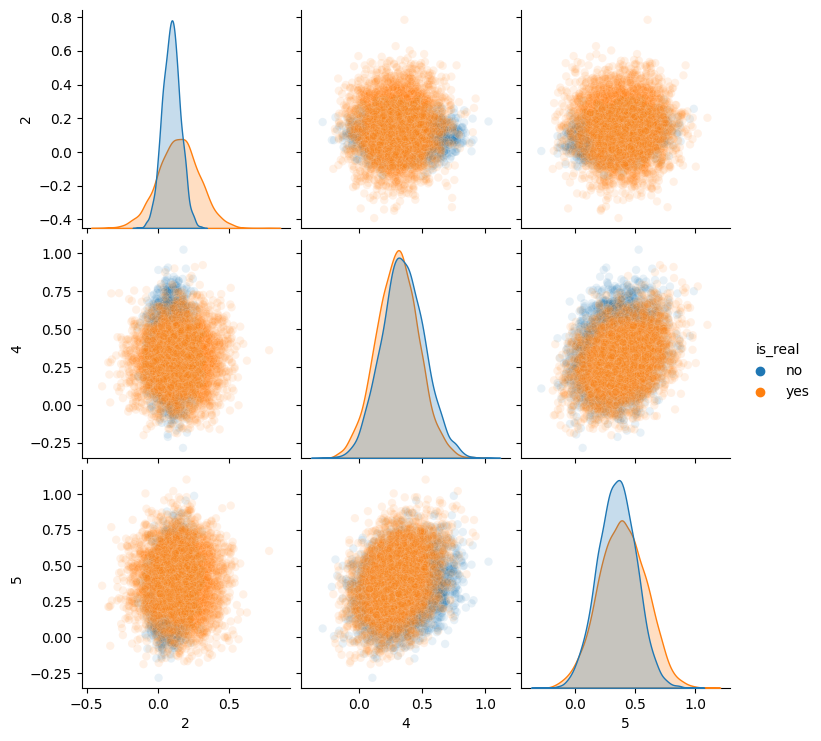

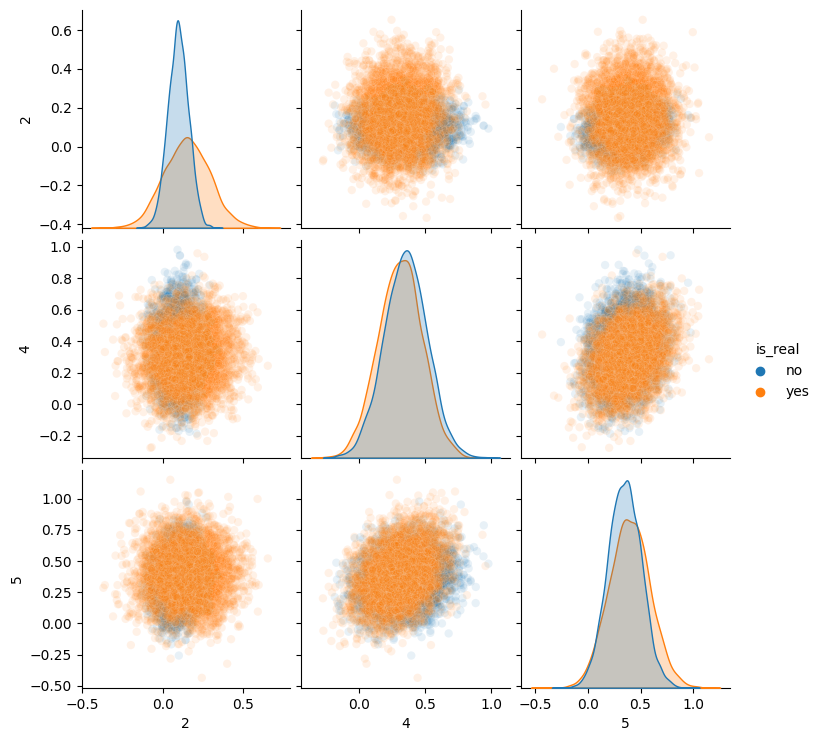

In [26]:
# Visualizing what pairwise multivariate distributions of inception features look like

indices = [2, 4, 5]

fake_dist = MultivariateNormal(mu_fake[indices], sigma_fake[indices][:, indices])
fake_samples = fake_dist.sample((5000,))

real_dist = MultivariateNormal(mu_real[indices], sigma_real[indices][:, indices])
real_samples = real_dist.sample((5000,))

import pandas as pd

df_fake = pd.DataFrame(fake_samples.numpy(), columns=indices)
df_real = pd.DataFrame(real_samples.numpy(), columns=indices)

df_fake['is_real'] = 'no'
df_real['is_real'] = 'yes'

df = pd.concat([df_fake, df_real])

sns.pairplot(df, plot_kws={'alpha':0.1}, hue='is_real')
plt.show()

In [27]:
# Calulating the FID and evaluate our GAN 

with torch.no_grad():
    print(frechet_distance(mu_real, mu_fake, sigma_real, sigma_fake).item())

87.92151641845703
